In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplcursors

In [2]:
plt.style.use("ggplot")

## Load Data

In [3]:
# Sample of accounts
df_accts = pd.DataFrame(
    {
        "account_id": range(1, 11),
        "username": ["user_" + str(i) for i in range(1, 11)],
        "signup_timestamp": [dt.datetime(2022, 1, np.random.randint(1, 31), np.random.randint(0, 23), np.random.randint(0, 59), np.random.randint(0, 59)) for _ in range(10)]
    } 
)

df_accts

,account_id,username,signup_timestamp
0,1,user_1,2022-01-08 15:55:24
1,2,user_2,2022-01-23 05:52:13
2,3,user_3,2022-01-30 20:51:50
3,4,user_4,2022-01-19 11:52:47
4,5,user_5,2022-01-23 17:46:58
5,6,user_6,2022-01-15 06:31:16
6,7,user_7,2022-01-27 21:24:12
7,8,user_8,2022-01-23 18:23:45
8,9,user_9,2022-01-25 05:28:25
9,10,user_10,2022-01-03 08:38:58


In [4]:
# Sample of follower data
df_followers = pd.DataFrame(
    {
        "account_id": [np.random.randint(1, 10) for _ in range(10)],
        "follower_account_id": [np.random.randint(1, 10) for _ in range(10)],
        "timestamp": [dt.datetime(2022, 2, np.random.randint(1, 28), np.random.randint(0, 23), np.random.randint(0, 59), np.random.randint(0, 59)) for _ in range(10)]
    } 
)

df_followers

,account_id,follower_account_id,timestamp
0,6,9,2022-02-15 04:14:04
1,3,9,2022-02-12 05:14:10
2,7,3,2022-02-16 07:08:01
3,6,3,2022-02-13 08:09:54
4,6,4,2022-02-25 14:07:00
5,7,3,2022-02-20 21:26:49
6,4,2,2022-02-02 21:26:33
7,2,3,2022-02-09 04:09:05
8,3,2,2022-02-10 03:00:53
9,4,3,2022-02-10 07:11:29


## Create Graph

### Create Directed Graph

In [5]:
G = nx.DiGraph()


In [6]:
# Add accounts as nodes to Graph
accts = df_accts.account_id.unique().tolist()

for acct in accts:
    row = df_accts[df_accts["account_id"] == acct]
    username = row["username"].iloc[0]
    signup_timestamp = row["signup_timestamp"].iloc[0]
    G.add_node(acct, username=username, signup_timestamp=signup_timestamp)


In [7]:
# Add edges to Graph
accts_with_followers = df_followers.account_id.unique().tolist()

for acct in accts_with_followers:
    rows = df_followers[df_followers["account_id"] == acct]
    for _, row in rows.iterrows():
        follower_account_id = row["follower_account_id"]
        timestamp = row["timestamp"]

        G.add_edge(follower_account_id, acct, timestamp=timestamp)

## Plot Graph

### Plot Directed Graph

In [20]:
pos = nx.spring_layout(G, k=0.9, seed=1)

In [21]:
# Make node sizes equal to number of edges/ followers a node has
node_sizes = [
     500 + 1000 * df_followers[df_followers["account_id"] == acct_id]["follower_account_id"].nunique() 
     for acct_id in pos.keys()
]

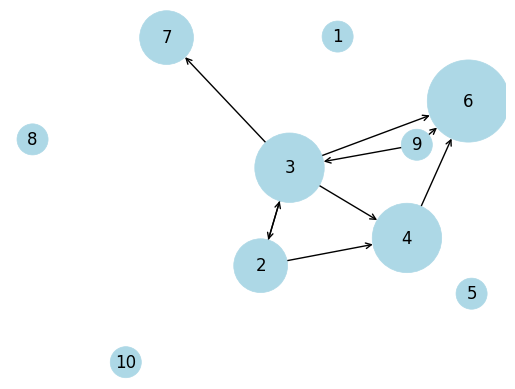

In [22]:
# Draw nodes 
nodes = nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=node_sizes)

# Draw edges
edges = nx.draw_networkx_edges(
    G, 
    pos, 
    node_size=node_sizes, 
    arrowstyle="->", 
    arrowsize=10, 
    width=1
)

# Draw labels
labels = nx.draw_networkx_labels(G, pos=pos)

# Plot graph
ax = plt.gca()
ax.set_axis_off()
plt.show()

In [11]:
df_followers.groupby("account_id")["follower_account_id"].nunique()

account_id
2    1
3    2
4    2
6    3
7    1
Name: follower_account_id, dtype: int64

## Node-based Features

In [12]:
# Create dataframe with all nodes in graph to store features
df_features = pd.DataFrame({"account_id": accts})
df_features

,account_id
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


### Node Degrees

In [13]:
# Node degree feature
df_features["feature_node_degree"] = 0

for node in G.nodes():
    result = G.degree(node)
    df_features.loc[df_features["account_id"] == node, "feature_node_degree"] = result

In [14]:
# Node out-degree feature
df_features["feature_node_out_degree"] = 0

for node in G.nodes():
    result = G.out_degree(node)
    df_features.loc[df_features["account_id"] == node, "feature_node_out_degree"] = result

In [15]:
# Node in-degree feature
df_features["feature_node_in_degree"] = 0

for node in G.nodes():
    result = G.in_degree(node)
    df_features.loc[df_features["account_id"] == node, "feature_node_in_degree"] = result

### Node Centrality

In [16]:
# PageRank feature
df_features["feature_pagerank"] = 0

results = nx.pagerank(G)

# Store results in df
for node, result in results.items():
    df_features.loc[df_features["account_id"] == node, "feature_pagerank"] = result

In [17]:
# Betweenness centrality feature
df_features["feature_betweenness_centrality"] = 0

results = nx.betweenness_centrality(G)

# Store results in df
for node, result in results.items():
    df_features.loc[df_features["account_id"] == node, "feature_betweenness_centrality"] = result

In [18]:
# Closeness centrality feature
df_features["feature_closeness_centrality"] = 0

results = nx.closeness_centrality(G)

# Store results in df
for node, result in results.items():
    df_features.loc[df_features["account_id"] == node, "feature_closeness_centrality"] = result

In [19]:
df_features.sort_values("feature_closeness_centrality", ascending=False)

,account_id,feature_node_degree,feature_node_out_degree,feature_node_in_degree,feature_pagerank,feature_betweenness_centrality,feature_closeness_centrality
5,6,3,0,3,0.231275,0.000000,0.355556
3,4,3,1,2,0.131406,0.006944,0.250000
2,3,6,4,2,0.130945,0.062500,0.222222
6,7,1,0,1,0.092215,0.000000,0.200000
1,2,3,2,1,0.092215,0.000000,0.148148
0,1,0,0,0,0.064389,0.000000,0.000000
4,5,0,0,0,0.064389,0.000000,0.000000
7,8,0,0,0,0.064389,0.000000,0.000000
8,9,2,2,0,0.064389,0.000000,0.000000
9,10,0,0,0,0.064389,0.000000,0.000000
